# Import the libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from skimage.io import imread_collection
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import hog, local_binary_pattern, hessian_matrix, hessian_matrix_eigvals
from skimage.filters import gabor
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE
from pathlib import Path
from PIL import Image
from google.colab import drive

# Define the paths for train, validation, and test datasets

In [2]:
drive.mount('/content/gdrive')

train_data_path = Path("/content/gdrive/MyDrive/AI PROJECT DATASET/train")
valid_data_path = Path("/content/gdrive/MyDrive/AI PROJECT DATASET/valid")
test_data_path = Path("/content/gdrive/MyDrive/AI PROJECT DATASET/test")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Feature Extraction

In [3]:
def extract_features(image_dir,label, batch_size=128, resize_dim=(128, 128)):
    image_collection = imread_collection(image_dir + '/*.jpg')  # images are in JPEG format
    features = []
    labels = []
    num_images = len(image_collection)
    num_batches = (num_images + batch_size - 1) // batch_size

    for batch_idx in tqdm(range(num_batches), desc='Extracting features'):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, num_images)
        batch_images = image_collection[start_idx:end_idx]

        batch_features = []
        batch_labels = []
        for image in batch_images:
            # Resize image
            resized_image = resize(image, resize_dim)

            # Convert image to grayscale
            gray_image = rgb2gray(resized_image)

            # Extract HOG features for each image
            hog_features = hog(gray_image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False)

            # Extract LBP features
            lbp_radius = 3
            lbp_points = 8 * lbp_radius
            lbp = local_binary_pattern(gray_image, lbp_points, lbp_radius, method='uniform')
            lbp_histogram, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp_points + 3), range=(0, lbp_points + 2))
            lbp_features = lbp_histogram.astype(np.float32)

            # Extract Gabor filter features
            gabor_filters = []
            gabor_orientations = [0, np.pi/4, np.pi/2, 3*np.pi/4]
            gabor_frequencies = [0.1, 0.2, 0.3, 0.4]
            for freq in gabor_frequencies:
                for theta in gabor_orientations:
                    gabor_filters.append(gabor(gray_image, frequency=freq, theta=theta))
            gabor_features = np.array([np.mean(np.abs(gabor_image)) for gabor_image in gabor_filters], dtype=np.float32)

            # Extract color histogram
            color_histogram, _ = np.histogram(resized_image.flatten(), bins=256, range=(0, 256))
            color_histogram_features = color_histogram.astype(np.float32)

            # # Extract edge features
            # edges = cv2.Canny(image,100,200)
            # edges_flat = edges.flatten()

            # # Extract shape features
            # H = hessian_matrix(image, sigma=1)
            # _, l2, _ = hessian_matrix_eigvals(H)
            # shape_features = l2.flatten().astype(np.float32)

            # Combine all features
            combined_features = np.concatenate((hog_features, lbp_features, gabor_features, color_histogram_features))
            batch_features.append(combined_features)
            batch_labels.append(label)

        features.extend(batch_features)
        labels.extend(batch_labels)

    return np.array(features), np.array(labels)


# Function to load the images and generate labels

In [4]:
def load_images_and_labels(dataset_path):
    images = []
    labels = []
    class_names = ['Asian Green Bee-Eater', 'Indian Peacock', 'Common Kingfisher']
    for i, class_name in tqdm(enumerate(class_names), desc = "Loading images and labels"):
        class_dir = os.path.join(dataset_path, class_name)

        # image_features, image_labels = extract_features(class_dir, i)

        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = Image.open(image_path)


            images.append(np.array(image))
            labels.append(i)

        # images.append(image_features)
        # labels.append(image_labels)
    return np.array(images), np.array(labels)

# Load train, validation, and test datasets

In [5]:
X_train, y_train = load_images_and_labels(train_data_path)
X_valid, y_valid = load_images_and_labels(valid_data_path)
X_test, y_test = load_images_and_labels(test_data_path)

Loading images and labels: 3it [00:12,  4.16s/it]
Loading images and labels: 3it [00:02,  1.12it/s]
Loading images and labels: 3it [00:03,  1.01s/it]


# Preprocess and resize the image data

In [6]:
def preprocess_resize(images):
    processed_images = []
    for image in images:
        # Resize the image to a desired size (e.g., 32x32 pixels)
        resized_image = Image.fromarray(image).resize((128, 128))
        # Convert the resized image to a numpy array
        processed_images.append(np.array(resized_image))
    return np.array(processed_images)

# Preprocess and resize the train, validation, and test datasets

In [7]:
X_train = preprocess_resize(X_train)
X_valid = preprocess_resize(X_valid)
X_test = preprocess_resize(X_test)

# Flatten the image data

In [8]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Define the hyperparameters for tuning

In [9]:
hyperparameters = {
    'max_depth': [20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform hyperparameter tuning using GridSearchCV

In [10]:
print(X_train.shape)
print(y_train.shape)

X_train = np.array(X_train)
y_train = np.array(y_train)

classifier = DecisionTreeClassifier()
grid_search = GridSearchCV(classifier, hyperparameters, scoring='accuracy', cv=2)
grid_search.fit(X_train, y_train)

(1935, 49152)
(1935,)


GridSearchCV(cv=2, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [20, 30, 40],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

# Retrieve the best model from GridSearchCV

In [11]:
classifier = grid_search.best_estimator_

# Set aside a portion of the test set for final evaluation

In [12]:
X_final_test, y_final_test = X_test, y_test

# Randomly select 20% of the remaining data as labeled and the rest as unlabeled

In [13]:
labeled_data_ratio = 0.2
num_labeled_data = int(labeled_data_ratio * X_train.shape[0])
random_indices = np.random.permutation(X_train.shape[0])
labeled_indices = random_indices[:num_labeled_data]
unlabeled_indices = random_indices[num_labeled_data:]


# Create labeled and unlabeled datasets

In [14]:
X_labeled, y_labeled = X_train[labeled_indices], y_train[labeled_indices]
X_unlabeled, y_unlabeled = X_train[unlabeled_indices], y_train[unlabeled_indices]


# Combine labeled data with original labeled data

In [15]:
X_combined_train = np.concatenate((X_labeled, X_train))
y_combined_train = np.concatenate((y_labeled, y_train))

# Train the decision tree classifier using combined labeled dataset

In [16]:
classifier.fit(X_combined_train, y_combined_train)

DecisionTreeClassifier(max_depth=30)

In [17]:
# Set the number of iterations and confidence thresholds for pseudo-labeling
num_iterations = 10
confidence_threshold_low = 0.15
confidence_threshold_high = 0.85

for iteration in range(num_iterations):
    # Predict (pseudo-label) the unlabeled data
    y_unlabeled_pred = classifier.predict(X_unlabeled)
    y_unlabeled_prob = classifier.predict_proba(X_unlabeled)

    # print("Epoch : {} => unlabeled Probability = {}".format(iteration + 1, y_unlabeled_prob))
    # Filter high-confidence pseudo-labeled data
    high_confidence_indices = np.where(
        (y_unlabeled_prob.max(axis=1) >= confidence_threshold_high) |
        (y_unlabeled_prob.max(axis=1) <= confidence_threshold_low)
    )[0]
    X_high_confidence = X_unlabeled[high_confidence_indices]
    y_high_confidence = y_unlabeled_pred[high_confidence_indices]

    # Mix high-confidence pseudo-labeled data with labeled data
    X_new_labeled = np.concatenate((X_labeled, X_high_confidence))
    y_new_labeled = np.concatenate((y_labeled, y_high_confidence))

    # Combine the new labeled dataset with the original unlabeled data
    X_combined_train = np.concatenate((X_new_labeled, X_unlabeled))
    y_combined_train = np.concatenate((y_new_labeled, y_unlabeled))

    # Retrain the classifier using the updated labeled dataset
    classifier.fit(X_combined_train, y_combined_train)

    # Update the labeled and unlabeled datasets for the next iteration
    X_labeled, y_labeled = X_new_labeled, y_new_labeled
    X_unlabeled, y_unlabeled = X_unlabeled[~high_confidence_indices], y_unlabeled[~high_confidence_indices]
    print("Epoch : {} Completed".format(iteration + 1))

Epoch : 1 Completed
Epoch : 2 Completed
Epoch : 3 Completed
Epoch : 4 Completed
Epoch : 5 Completed
Epoch : 6 Completed
Epoch : 7 Completed
Epoch : 8 Completed
Epoch : 9 Completed
Epoch : 10 Completed


# Evaluation on Validation Set

In [18]:
# Predict on the validation set
y_valid_pred = classifier.predict(X_valid)

# Calculate evaluation metrics on the validation set
accuracy = accuracy_score(y_valid, y_valid_pred)
precision = precision_score(y_valid, y_valid_pred, average='macro')
recall = recall_score(y_valid, y_valid_pred, average='macro')
f1 = f1_score(y_valid, y_valid_pred, average='macro')
confusion = confusion_matrix(y_valid, y_valid_pred)

print("Validation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(confusion)

Validation Metrics:
Accuracy: 0.5447941888619855
Precision: 0.5451533779378546
Recall: 0.5447653302302621
F1-score: 0.5448588709033194
Confusion Matrix:
[[79 28 31]
 [26 73 38]
 [34 31 73]]


# Evaluation on Final Test Set

In [19]:
# Predict on the final test set
y_final_test_pred = classifier.predict(X_final_test)

# Calculate evaluation metrics on the final test set
accuracy = accuracy_score(y_final_test, y_final_test_pred)
precision = precision_score(y_final_test, y_final_test_pred, average='macro')
recall = recall_score(y_final_test, y_final_test_pred, average='macro')
f1 = f1_score(y_final_test, y_final_test_pred, average='macro')
confusion = confusion_matrix(y_final_test, y_final_test_pred)

print("Final Test Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(confusion)

Final Test Metrics:
Accuracy: 0.45346062052505964
Precision: 0.45392105720744214
Recall: 0.4534943473792395
F1-score: 0.453659125813187
Confusion Matrix:
[[67 27 46]
 [36 65 38]
 [39 43 58]]


# Perform t-SNE dimensionality reduction on the final test set

In [20]:
tsne = TSNE(n_components=2, random_state=42)
X_final_test_tsne = tsne.fit_transform(X_final_test)

# Plot t-SNE graph

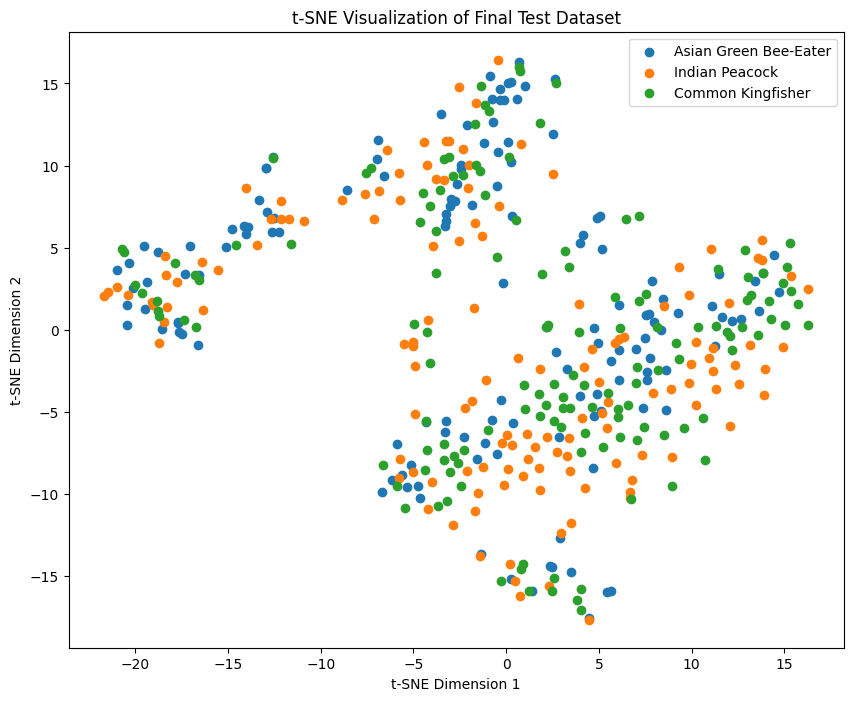

In [21]:
class_names = ['Asian Green Bee-Eater', 'Indian Peacock', 'Common Kingfisher']
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    indices = np.where(y_final_test == i)
    plt.scatter(X_final_test_tsne[indices, 0], X_final_test_tsne[indices, 1], label=class_names[i])

plt.title('t-SNE Visualization of Final Test Dataset')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

# Plot Confusion Matrix

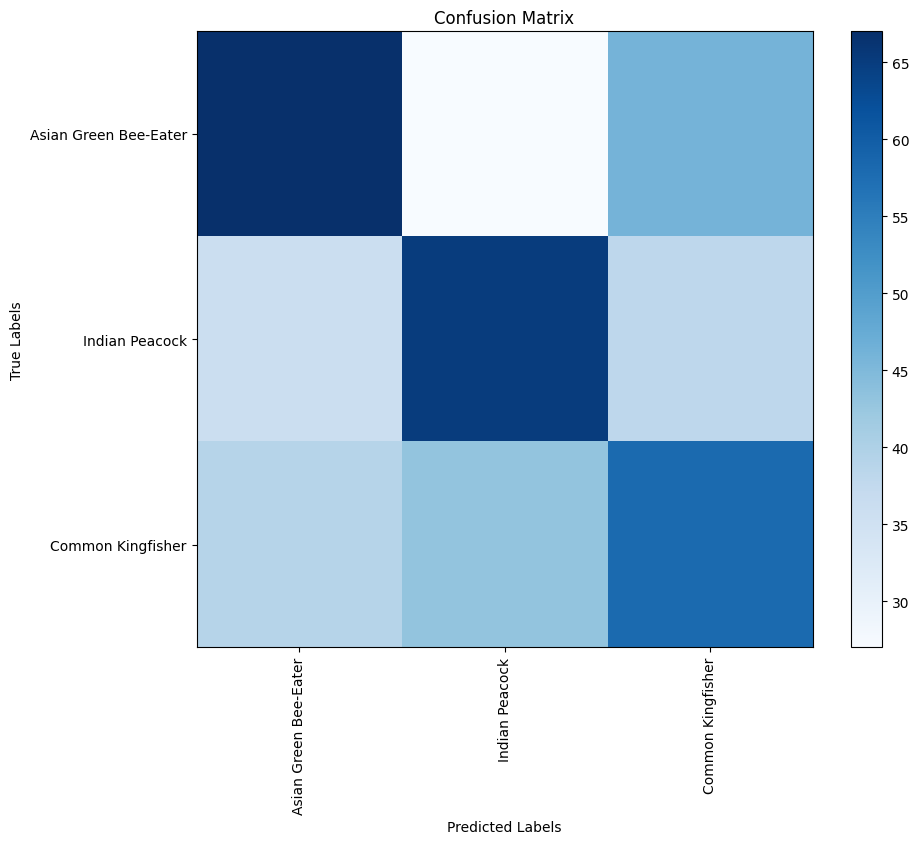

In [22]:
plt.figure(figsize=(10, 8))
plt.imshow(confusion, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(class_names)), class_names, rotation=90)
plt.yticks(np.arange(len(class_names)), class_names)
plt.colorbar()
plt.show()

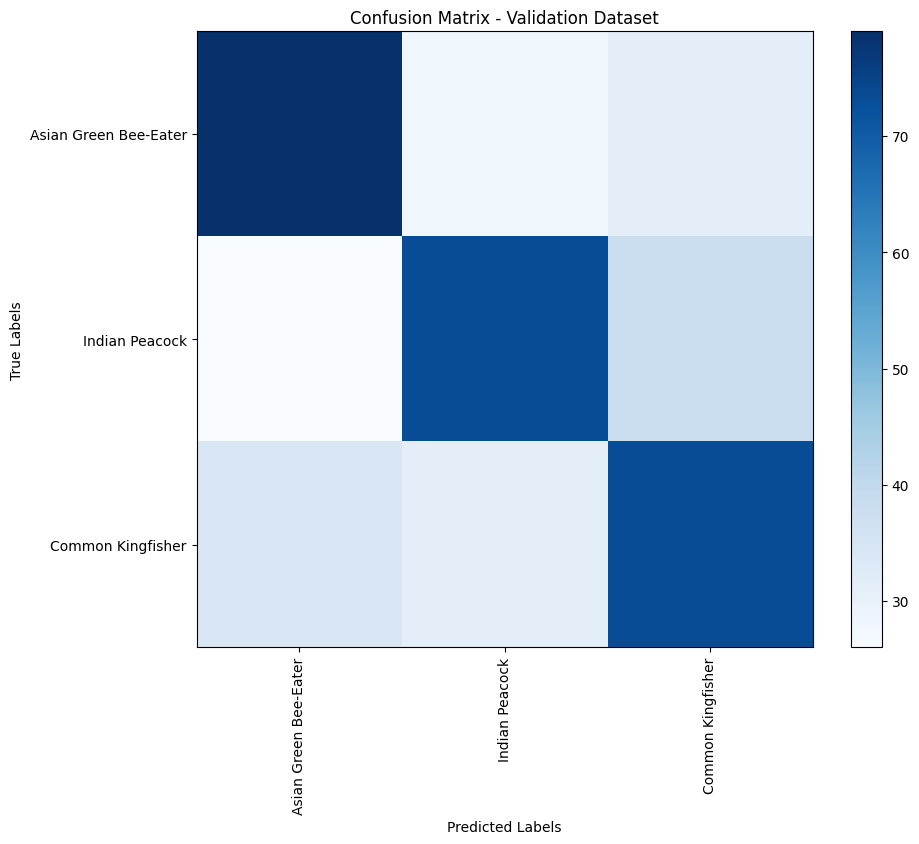

In [23]:
confusion = confusion_matrix(y_valid, y_valid_pred)
plt.figure(figsize=(10, 8))
plt.imshow(confusion, cmap='Blues')
plt.title('Confusion Matrix - Validation Dataset')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(class_names)), class_names, rotation=90)
plt.yticks(np.arange(len(class_names)), class_names)
plt.colorbar()
plt.show()